<a href="https://www.kaggle.com/code/djebril/pneumonia-detection-densnet-161?scriptVersionId=238841005" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 🏛️ Chest X-Ray Classification: Pneumonia Detection using Deep Learning

## Notebook Overview

This notebook presents a deep learning solution for detecting **pneumonia** from chest X-ray images using **convolutional neural networks (CNNs)** implemented in **PyTorch**. The goal is to assist in early diagnosis by classifying images into two categories: `NORMAL` or `PNEUMONIA`.

---

### 🦠 About Pneumonia

Pneumonia is an inflammatory condition of the lungs primarily affecting the alveoli. It can be caused by infections such as bacteria, viruses, or fungi. Detecting pneumonia from chest X-rays is a common diagnostic method, but manual interpretation can be time-consuming and prone to human error. Automating this process using deep learning has great potential in medical imaging diagnostics.

---

### 🧠 Deep Learning & Computer Vision

Deep learning — particularly **Convolutional Neural Networks (CNNs)** — has revolutionized the field of **computer vision**. CNNs are capable of automatically extracting spatial features from images, making them highly effective for tasks like object detection, segmentation, and classification.

In this project, we apply transfer learning using a **pre-trained DenseNet-161 model**, which was originally trained on the ImageNet dataset, to classify chest X-rays with high accuracy.

---

### 🤖 What is DenseNet?

**DenseNet (Densely Connected Convolutional Networks)** is a type of CNN architecture where each layer is directly connected to every other layer in a feed-forward fashion. This design helps alleviate the vanishing gradient problem, strengthens feature propagation, and encourages feature reuse.

**DenseNet-161** is one of the deeper variants of the architecture, offering excellent performance on image classification tasks.

---

### 🔍 Model Training & Evaluation

We fine-tuned the DenseNet-161 model on a curated dataset of chest X-rays. To ensure robustness:
- We applied **stratified K-Fold Cross Validation**
- Used **class weighting** to handle imbalanced data
- Performed data augmentation to improve generalization

The final model achieved strong results on the test set:

| Metric                    | Score     |
|---------------------------|-----------|
| **Test Accuracy**         | 95.79%    |
| **Macro-Averaged F1-Score** | 94.76%  |
| **F1-Score (NORMAL)**      | 92.43%    |
| **F1-Score (PNEUMONIA)**   | 97.08%    |

The confusion matrix and classification report further confirm the model's ability to distinguish between the two classes effectively.

---

This notebook demonstrates how **deep learning in PyTorch** can be leveraged for real-world computer vision applications in the healthcare domain.

# Chest X-Ray Classification with DenseNet161: Pneumonia Detection

## 1. 🧾 Setup & Configuration  

### 🧪 Setup Environment

Basic imports and input/output directory setup.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest_xray/chest_xray/val/PNEUMONIA/person1950_bacteria_4881.jpeg
/kaggle/input/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1431-0001.jpeg
/kaggle/input/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg
/kaggle/input/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-

### 🧾 Dataset Reorganization Script

Creates a stratified train/test (and optionally val) split and reorganizes the dataset into a standard ML directory structure.

In [2]:
#!/usr/bin/env python3

import os
import glob
import shutil
from sklearn.model_selection import train_test_split
from collections import Counter

# --- Configuration ---
DEFAULT_SOURCE_DIR = "../input/chest_xray/chest_xray/"
DEFAULT_OUTPUT_DIR = "./chest_xray_stratified"
TRAIN_RATIO = 0.85
VAL_RATIO = 0
TEST_RATIO = 0.15
CLASSES = ["NORMAL", "PNEUMONIA"]
RANDOM_SEED = 42


def create_stratified_split(source_dir, output_dir, train_ratio, val_ratio, test_ratio):
    print(f"Source directory: {source_dir}")
    print(f"Output directory: {output_dir}")
    print(f"Split ratios: Train={train_ratio:.2f}, Val={val_ratio:.2f}, Test={test_ratio:.2f}")

    if not os.path.isdir(source_dir):
        print(f"\nERROR: Source directory \t'{source_dir}' not found.")
        return

    all_files = []
    all_labels = []

    print("\nGathering image files...")
    for split_type in ["train", "val", "test"]:
        split_path = os.path.join(source_dir, split_type)
        if not os.path.isdir(split_path):
            print(f"Warning: Subdirectory \t'{split_type}' not found in source. Skipping.")
            continue

        for class_name in CLASSES:
            class_path = os.path.join(split_path, class_name)
            if not os.path.isdir(class_path):
                print(f"Warning: Class directory \t'{class_path}' not found. Skipping.")
                continue

            image_patterns = ["*.jpeg", "*.jpg", "*.png"]
            class_files = []
            for pattern in image_patterns:
                class_files.extend(glob.glob(os.path.join(class_path, pattern)))

            all_files.extend(class_files)
            all_labels.extend([class_name] * len(class_files))
            print(f"  Found {len(class_files)} images in \t'{class_path}'")

    if not all_files:
        print("\nERROR: No image files found in the source directory structure.")
        return

    print(f"\nTotal images found: {len(all_files)}")
    print(f"Initial class distribution: {Counter(all_labels)}")

    print("\nPerforming stratified split...")

    train_val_files, test_files, train_val_labels, test_labels = train_test_split(
        all_files, all_labels,
        test_size=test_ratio,
        stratify=all_labels,
        random_state=RANDOM_SEED
    )
    if val_ratio > 0:
        relative_val_ratio = val_ratio / (train_ratio + val_ratio)
        train_files, val_files, train_labels, val_labels = train_test_split(
            train_val_files, train_val_labels,
            test_size=relative_val_ratio,
            stratify=train_val_labels,
            random_state=RANDOM_SEED
        )
    else:
        # No validation set — assign entire train_val to train
        train_files, train_labels = train_val_files, train_val_labels
        val_files, val_labels = [], []  # Empty lists — no validation data


    print("Split completed.")
    print(f"  Train set size: {len(train_files)}\t({Counter(train_labels)})")
    print(f"  Validation set size: {len(val_files)}\t({Counter(val_labels)})")
    print(f"  Test set size: {len(test_files)}\t({Counter(test_labels)})")

    print(f"\nCreating output directory structure at \t'{output_dir}'...")
    if os.path.exists(output_dir):
        print(f"Warning: Output directory \t'{output_dir}' already exists. Removing and recreating.")
        shutil.rmtree(output_dir)

    os.makedirs(output_dir, exist_ok=True)

    split_data = {
        "train": (train_files, train_labels),
        "val": (val_files, val_labels),
        "test": (test_files, test_labels)
    }

    for split_name, (files, labels) in split_data.items():
        print(f"Copying {split_name} files...")
        split_out_dir = os.path.join(output_dir, split_name)
        os.makedirs(split_out_dir, exist_ok=True)

        copied_count = 0
        for class_name in CLASSES:
            class_out_dir = os.path.join(split_out_dir, class_name)
            os.makedirs(class_out_dir, exist_ok=True)

            class_split_files = [f for f, l in zip(files, labels) if l == class_name]

            for src_file in class_split_files:
                try:
                    filename = os.path.basename(src_file)
                    dst_file = os.path.join(class_out_dir, filename)
                    shutil.copy2(src_file, dst_file)
                    copied_count += 1
                except Exception as e:
                    print(f"Error copying file {src_file} to {dst_file}: {e}")
        print(f"  Copied {copied_count} files for {split_name} split.")

    print("\nDataset splitting and reorganization complete.")
    print(f"New dataset is located at: {output_dir}")


# --- Run directly in Kaggle ---
create_stratified_split(
    source_dir=DEFAULT_SOURCE_DIR,
    output_dir=DEFAULT_OUTPUT_DIR,
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO
)


Source directory: ../input/chest_xray/chest_xray/
Output directory: ./chest_xray_stratified
Split ratios: Train=0.85, Val=0.00, Test=0.15

Gathering image files...
  Found 1341 images in 	'../input/chest_xray/chest_xray/train/NORMAL'
  Found 3875 images in 	'../input/chest_xray/chest_xray/train/PNEUMONIA'
  Found 8 images in 	'../input/chest_xray/chest_xray/val/NORMAL'
  Found 8 images in 	'../input/chest_xray/chest_xray/val/PNEUMONIA'
  Found 234 images in 	'../input/chest_xray/chest_xray/test/NORMAL'
  Found 390 images in 	'../input/chest_xray/chest_xray/test/PNEUMONIA'

Total images found: 5856
Initial class distribution: Counter({'PNEUMONIA': 4273, 'NORMAL': 1583})

Performing stratified split...
Split completed.
  Train set size: 4977	(Counter({'PNEUMONIA': 3632, 'NORMAL': 1345}))
  Validation set size: 0	(Counter())
  Test set size: 879	(Counter({'PNEUMONIA': 641, 'NORMAL': 238}))

Creating output directory structure at 	'./chest_xray_stratified'...
Copying train files...
  Copie

### 🔧 Imports and Setup

Import necessary libraries and display version information for reproducibility.

In [3]:

# Import necessary libraries and define constants like data paths, image size, batch size, etc.

# %% 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, WeightedRandomSampler, SubsetRandomSampler
import torchvision
from torchvision import datasets, models, transforms
from IPython.display import FileLink
import shutil
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import seaborn as sns
import pandas as pd
from collections import Counter

print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")


PyTorch Version: 2.5.1+cu124
Torchvision Version: 0.20.1+cu124


### 📁 Dataset Directory Setup

This section sets up the base data directory path and ensures the expected folder structure exists.  
If the main dataset directory is not found, it creates dummy directories to match the expected structure for training.

#### ✅ What This Does:
- Defines the dataset root directory
- Checks if the directory exists
- If not, creates dummy `train`, `val`, and `test` folders with `NORMAL` and `PNEUMONIA` subfolders

This helps prevent errors during data loading when testing the pipeline before the real dataset is available.

In [4]:

# --- Configuration ---
data_dir = "./chest_xray_stratified"

# Check if the directory exists (basic check)
if not os.path.isdir(data_dir):
    print(f"WARNING: Data directory not found at {data_dir}. Please ensure the path is correct.")
    print("Creating dummy data directories for structure testing...")
    os.makedirs(os.path.join(data_dir, 'train', 'NORMAL'), exist_ok=True)
    os.makedirs(os.path.join(data_dir, 'train', 'PNEUMONIA'), exist_ok=True)
    os.makedirs(os.path.join(data_dir, 'val', 'NORMAL'), exist_ok=True)
    os.makedirs(os.path.join(data_dir, 'val', 'PNEUMONIA'), exist_ok=True)
    os.makedirs(os.path.join(data_dir, 'test', 'NORMAL'), exist_ok=True)
    os.makedirs(os.path.join(data_dir, 'test', 'PNEUMONIA'), exist_ok=True)
    



### 🧠 Training Configuration

This section defines the key hyperparameters used throughout the training pipeline.

In [5]:
img_size = 224 # DenseNet input size
batch_size = 32
num_epochs = 10 # Adjust as needed
num_workers = 4 # Number of worker processes for data loading
learning_rate = 0.001
momentum = 0.9
num_folds = 5 # For cross-validation

### 📦 Device Setup & Reproducibility  
Sets device to GPU if available and fixes random seeds for reproducibility.

In [6]:


# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# For reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


Using device: cuda:0


## 2. 🖼️ Data Preparation & Exploration  

### 🔄 Data Augmentation & Transformations  
Defines training, validation, and test transforms including resizing, channel conversion, augmentation, and normalization.

In [7]:

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.Grayscale(num_output_channels=3), # Convert grayscale to 3 channels for DenseNet
        transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1), # Subtle color jitter
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet stats
    ]),
    'val': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### ⏏️ Load Datasets with ImageFolder  
Loads training, validation, and test datasets using `ImageFolder`, checks class distribution, and handles errors gracefully.

In [8]:
from torchvision import datasets
from collections import Counter
import os

# Only attempt to load 'val' if it contains images
phases = ['train', 'test']  # Default: skip val if empty

# Check if val directory exists and has images
val_path_normal = os.path.join(data_dir, 'val', 'NORMAL')
val_path_pneumonia = os.path.join(data_dir, 'val', 'PNEUMONIA')

# If both class folders exist and are non-empty, include 'val'
if (
    os.path.exists(val_path_normal) and os.listdir(val_path_normal) and
    os.path.exists(val_path_pneumonia) and os.listdir(val_path_pneumonia)
):
    phases = ['train', 'val', 'test']
    print("Validation set found and will be used.")
else:
    print("Validation set is missing or empty. Skipping validation.")

# Load datasets only for available phases
try:
    image_datasets = {
        x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
        for x in phases
    }

    dataset_sizes = {x: len(image_datasets[x]) for x in phases}
    class_names = image_datasets['train'].classes
    num_classes = len(class_names)

    print(f"Dataset sizes: {dataset_sizes}")
    print(f"Class names: {class_names}")
    print(f"Number of classes: {num_classes}")

    # Show training class distribution
    train_targets = [label for _, label in image_datasets['train'].samples]
    print(f"Training set class distribution: {Counter(train_targets)}")
    print("Class distribution details:", {class_names[k]: v for k, v in Counter(train_targets).items()})

except Exception as e:
    print(f"Error loading datasets: {e}")
    print("Using fallback values to continue safely.")
    image_datasets = {}
    dataset_sizes = {'train': 0, 'val': 0, 'test': 0}
    class_names = ['NORMAL', 'PNEUMONIA']
    num_classes = 2


# --- Define dataloaders after datasets are loaded ---


dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=(x == 'train'), num_workers=num_workers)
    for x in ['train', 'val', 'test'] if x in image_datasets
}

Validation set is missing or empty. Skipping validation.
Dataset sizes: {'train': 4977, 'test': 879}
Class names: ['NORMAL', 'PNEUMONIA']
Number of classes: 2
Training set class distribution: Counter({1: 3632, 0: 1345})
Class distribution details: {'NORMAL': 1345, 'PNEUMONIA': 3632}


### ⚖️ Class Weighting & Balanced Sampling  
Calculates class weights to handle dataset imbalance and applies weighted sampling in DataLoader.

In [9]:
# Calculate class weights for the training set


if dataset_sizes["train"] > 0:
    try:
        train_class_counts = Counter(train_targets)
        # Ensure we have counts for both classes, even if one is zero (unlikely with ImageFolder but safe)
        count_normal = train_class_counts.get(class_names.index("NORMAL"), 0)
        count_pneumonia = train_class_counts.get(class_names.index("PNEUMONIA"), 0)
        print(f"Training counts - NORMAL: {count_normal}, PNEUMONIA: {count_pneumonia}")

        # Method 1: Inverse frequency weighting
        # weight_normal = dataset_sizes["train"] / (num_classes * count_normal) if count_normal > 0 else 0
        # weight_pneumonia = dataset_sizes["train"] / (num_classes * count_pneumonia) if count_pneumonia > 0 else 0
        # class_weights = torch.tensor([weight_normal, weight_pneumonia], dtype=torch.float).to(device)
        # print(f"Calculated class weights: {class_weights}")
        # criterion = nn.CrossEntropyLoss(weight=class_weights) # Use CrossEntropyLoss if output is 2 neurons
        #//
        
        # Method 2: pos_weight for BCEWithLogitsLoss (Simpler for binary)
        # pos_weight = count_normal / count_pneumonia if count_pneumonia > 0 else 1.0
        # Using the formula: num_negatives / num_positives
        # Assuming PNEUMONIA is the positive class (index 1)
        #//
        
        # Method 3: 9isma oussama Come on
        if class_names.index("PNEUMONIA") == 1:
            pos_weight = count_normal / count_pneumonia if count_pneumonia > 0 else 1.0
        else: # Assuming NORMAL is the positive class (index 1)
            pos_weight = count_pneumonia / count_normal if count_normal > 0 else 1.0

        pos_weight_tensor = torch.tensor([pos_weight], dtype=torch.float).to(device)
        print(f"Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_tensor.item()}")
        # Use BCEWithLogitsLoss for binary classification with a single output neuron
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

        # Create WeightedRandomSampler for DataLoader to handle imbalance during batching
        # This is often more effective than just weighting the loss
        weights = [pos_weight if label == class_names.index("PNEUMONIA") else 1.0 for _, label in image_datasets["train"].samples]
        sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

        # Recreate the training DataLoader with the sampler
        # Note: shuffle must be False when using a sampler
        dataloaders["train"] = DataLoader(image_datasets["train"], batch_size=batch_size,
                                        sampler=sampler, num_workers=num_workers)
        print("Recreated training DataLoader with WeightedRandomSampler.")

    except Exception as e:
        print(f"Error calculating weights or creating sampler: {e}. Using default criterion.")
        # Fallback if calculation fails
        criterion = nn.BCEWithLogitsLoss() # Or nn.CrossEntropyLoss() if using 2 output neurons
        # Keep the original dataloader if sampler creation failed
        dataloaders["train"] = DataLoader(image_datasets["train"], batch_size=batch_size, shuffle=True, num_workers=num_workers)

else:
    print("Skipping weight calculation due to empty training set. Using default criterion.")
    criterion = nn.BCEWithLogitsLoss() # Default loss


Training counts - NORMAL: 1345, PNEUMONIA: 3632
Calculated pos_weight for BCEWithLogitsLoss: 0.3703193962574005
Recreated training DataLoader with WeightedRandomSampler.


### 🖼️ Visualize Sample Images  
Displays a batch of training images to verify data loading and transformations.

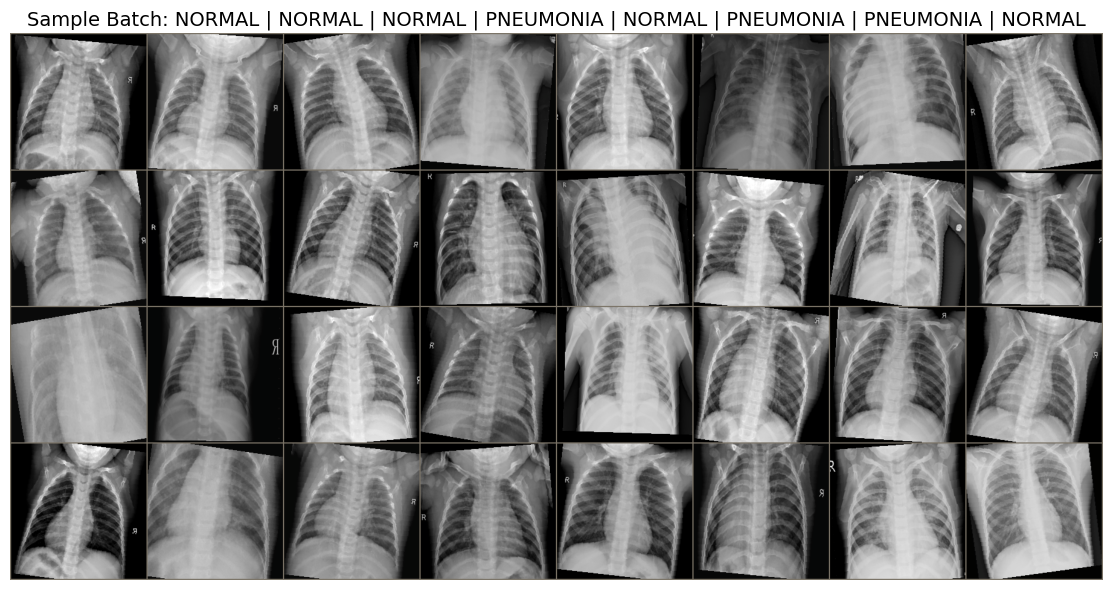

Sample batch displayed successfully.


In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor with better clarity."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure(figsize=(20, 6))  # Wider figure for larger batches
    plt.imshow(inp)
    plt.axis('off')  # Hide axes for cleaner look
    if title:
        plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Display a batch of images
if dataset_sizes['train'] > 0:
    try:
        inputs, classes = next(iter(dataloaders['train']))
        
        # Make a grid from batch (adjust nrow to control number of images per row)
        out = torchvision.utils.make_grid(inputs, nrow=8)  
        imshow(out, title='Sample Batch: ' + ' | '.join([class_names[x] for x in classes[:8]]))
        print("Sample batch displayed successfully.")
    except Exception as e:
        print(f"Could not display sample batch: {e}")
else:
    print("Skipping sample batch display due to empty training set.")

### 🧠 Model Definition  
Loads a pre-trained DenseNet161 model and modifies the final layer for binary classification.

In [11]:


# Load pre-trained DenseNet model (e.g., densenet161)
model_ft = models.densenet161(weights=models.DenseNet161_Weights.IMAGENET1K_V1)

# Modify the classifier for binary classification (1 output neuron for BCEWithLogitsLoss)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, 1) # Single output neuron

# Move model to the designated device (GPU or CPU)
model_ft = model_ft.to(device)

print(f"Loaded DenseNet161 and modified classifier for {num_classes} classes (1 output neuron).")
# print(model_ft) # Uncomment to see model structure

# Define the optimizer (Adam is often a good choice)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=learning_rate)

# Define a learning rate scheduler (optional but recommended)
# Reduces learning rate when a metric has stopped improving
scheduler_ft = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min', factor=0.1, patience=5, verbose=True)


Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:00<00:00, 182MB/s]


Loaded DenseNet161 and modified classifier for 2 classes (1 output neuron).


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 3. 🏋️ Model Training & Cross-Validation  
Contains model definition, training loop, K-Fold validation, and training history plotting.

### 🚀 Training Function  
Defines the training loop with validation, tracking loss and accuracy per epoch, and saves the best model weights.

In [12]:

def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=10, fold=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float("inf")
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    fold_text = f" Fold {fold+1} / {num_folds}" if fold is not None else ""
    print(f"\nStarting Training{fold_text}...")

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}{fold_text}")
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device).float().unsqueeze(1) # Ensure labels are float and shape [batch_size, 1] for BCEWithLogitsLoss

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    # Apply sigmoid to get probabilities and threshold for predictions
                    preds = torch.sigmoid(outputs) > 0.5
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += labels.size(0)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc.item()) # Use .item() to get Python number

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Deep copy the model if validation accuracy improves
            if phase == "val":
                # Scheduler step based on validation loss
                if scheduler:
                    scheduler.step(epoch_loss)

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    print(f"New best validation accuracy: {best_acc:.4f}")
                # Optional: save based on lowest validation loss as well or instead
                # if epoch_loss < best_loss:
                #     best_loss = epoch_loss
                #     best_model_wts = copy.deepcopy(model.state_dict())
                #     print(f"New best validation loss: {best_loss:.4f}")

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


### 📊 K-Fold Cross-Validation Training  
Performs stratified K-Fold Cross-Validation, trains multiple models, and selects the best one based on validation accuracy.

In [13]:


# Prepare dataset for K-Fold (using the original training dataset)
# Ensure we have a valid dataset to work with
if dataset_sizes["train"] > 0:
    train_dataset_full = image_datasets["train"]
    targets = np.array([s[1] for s in train_dataset_full.samples]) # Get all targets for stratification
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)

    fold_results = []
    all_fold_histories = []

    print(f"\nStarting {num_folds}-Fold Cross-Validation...")

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
        print(f"\n===== Fold {fold+1}/{num_folds} =====")

        # Create data samplers for current fold
        # Note: We are overriding the WeightedRandomSampler here for the CV split.
        # If imbalance is severe, applying weights *within* the fold training might be needed.
        train_subsampler = SubsetRandomSampler(train_idx)
        val_subsampler = SubsetRandomSampler(val_idx)

        # Define dataloaders for the current fold using the main training dataset
        fold_dataloaders = {
            "train": DataLoader(train_dataset_full, batch_size=batch_size, sampler=train_subsampler, num_workers=num_workers),
            "val": DataLoader(train_dataset_full, batch_size=batch_size, sampler=val_subsampler, num_workers=num_workers)
        }
        fold_dataset_sizes = {"train": len(train_idx), "val": len(val_idx)}

        # Initialize model, optimizer, and scheduler for each fold
        # This ensures each fold starts fresh
        model_fold = models.densenet161(weights=models.DenseNet161_Weights.IMAGENET1K_V1)
        num_ftrs = model_fold.classifier.in_features
        model_fold.classifier = nn.Linear(num_ftrs, 1) # Single output neuron
        model_fold = model_fold.to(device)

        # Re-calculate pos_weight for the specific training subset of this fold (more accurate)
        fold_train_targets = targets[train_idx]
        fold_class_counts = Counter(fold_train_targets)
        fold_count_normal = fold_class_counts.get(class_names.index("NORMAL"), 0)
        fold_count_pneumonia = fold_class_counts.get(class_names.index("PNEUMONIA"), 0)
        if class_names.index("PNEUMONIA") == 1:
            fold_pos_weight = fold_count_normal / fold_count_pneumonia if fold_count_pneumonia > 0 else 1.0
        else:
            fold_pos_weight = fold_count_pneumonia / fold_count_normal if fold_count_normal > 0 else 1.0
        fold_pos_weight_tensor = torch.tensor([fold_pos_weight], dtype=torch.float).to(device)
        criterion_fold = nn.BCEWithLogitsLoss(pos_weight=fold_pos_weight_tensor)
        print(f"Fold {fold+1} - Train counts: N={fold_count_normal}, P={fold_count_pneumonia}. Pos Weight: {fold_pos_weight:.4f}")

        optimizer_fold = optim.Adam(model_fold.parameters(), lr=learning_rate)
        scheduler_fold = lr_scheduler.ReduceLROnPlateau(optimizer_fold, mode="min", factor=0.1, patience=5, verbose=True)

        # Train the model for the current fold
        best_model_fold, history_fold = train_model(model_fold, criterion_fold, optimizer_fold, scheduler_fold,
                                                    fold_dataloaders, fold_dataset_sizes, num_epochs=num_epochs, fold=fold)

        # Save results for this fold
        fold_results.append({
            "fold": fold + 1,
            "model_state_dict": copy.deepcopy(best_model_fold.state_dict()), # Save state_dict
            "best_val_acc": max(history_fold["val_acc"])
        })
        all_fold_histories.append(history_fold)

        # Optional: Save the best model state_dict for each fold to a file
        # torch.save(best_model_fold.state_dict(), f"/home/ubuntu/model_fold_{fold+1}.pth")

    print("\nCross-validation finished.")

    # Find the best fold based on validation accuracy
    best_fold_result = max(fold_results, key=lambda x: x["best_val_acc"])
    print(f"\nBest fold: {best_fold_result['fold']} with Validation Accuracy: {best_fold_result['best_val_acc']:.4f}")

    # Load the best model from the best fold for final evaluation
    best_model = models.densenet161(weights=None) # Load architecture without pre-trained weights
    num_ftrs = best_model.classifier.in_features
    best_model.classifier = nn.Linear(num_ftrs, 1)
    best_model.load_state_dict(best_fold_result["model_state_dict"])
    best_model = best_model.to(device)

else:
    print("Skipping Cross-Validation due to empty training set.")
    # If no CV, train once on the original train/val split (if val exists)
    if dataset_sizes["val"] > 0:
        print("\nTraining on original Train/Val split (no cross-validation due to empty train set initially)...")
        # Ensure dataloaders use the weighted sampler if defined earlier
        cv_dataloaders = {
            "train": dataloaders.get("train"), # Use the one with sampler if created
            "val": dataloaders.get("val")
        }
        cv_dataset_sizes = {"train": dataset_sizes["train"], "val": dataset_sizes["val"]}

        if cv_dataloaders["train"] is not None and cv_dataloaders["val"] is not None:
            # Use the initially defined model, criterion, optimizer, scheduler
            best_model, history = train_model(model_ft, criterion, optimizer_ft, scheduler_ft,
                                              cv_dataloaders, cv_dataset_sizes, num_epochs=num_epochs)
            all_fold_histories = [history] # Store the single history
        else:
            print("Cannot proceed with single training run, dataloaders missing.")
            best_model = None # No model trained
            all_fold_histories = []
    else:
        print("Skipping training entirely as both train and val sets seem problematic.")
        best_model = None # No model trained
        all_fold_histories = []





Starting 5-Fold Cross-Validation...

===== Fold 1/5 =====
Fold 1 - Train counts: N=1076, P=2905. Pos Weight: 0.3704

Starting Training Fold 1 / 5...

Epoch 1/10 Fold 1 / 5
----------


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Loss: 0.1220 Acc: 0.9096
Val Loss: 0.1283 Acc: 0.8835
New best validation accuracy: 0.8835

Epoch 2/10 Fold 1 / 5
----------
Train Loss: 0.0884 Acc: 0.9382
Val Loss: 0.1331 Acc: 0.9418
New best validation accuracy: 0.9418

Epoch 3/10 Fold 1 / 5
----------
Train Loss: 0.0854 Acc: 0.9420
Val Loss: 0.0697 Acc: 0.9498
New best validation accuracy: 0.9498

Epoch 4/10 Fold 1 / 5
----------
Train Loss: 0.0749 Acc: 0.9478
Val Loss: 0.3391 Acc: 0.8464

Epoch 5/10 Fold 1 / 5
----------
Train Loss: 0.0672 Acc: 0.9525
Val Loss: 0.1484 Acc: 0.9468

Epoch 6/10 Fold 1 / 5
----------
Train Loss: 0.0738 Acc: 0.9518
Val Loss: 0.1941 Acc: 0.8213

Epoch 7/10 Fold 1 / 5
----------
Train Loss: 0.0667 Acc: 0.9523
Val Loss: 0.0679 Acc: 0.9669
New best validation accuracy: 0.9669

Epoch 8/10 Fold 1 / 5
----------
Train Loss: 0.0575 Acc: 0.9578
Val Loss: 0.0619 Acc: 0.9468

Epoch 9/10 Fold 1 / 5
----------
Train Loss: 0.0581 Acc: 0.9581
Val Loss: 0.0711 Acc: 0.9398

Epoch 10/10 Fold 1 / 5
----------
Train

## 4. 📉 Evaluation & Results  
Includes evaluation metrics (accuracy, F1-score), confusion matrix, and model saving.

### 📈 Plot Training History  
Visualizes the average training and validation loss & accuracy across all folds.

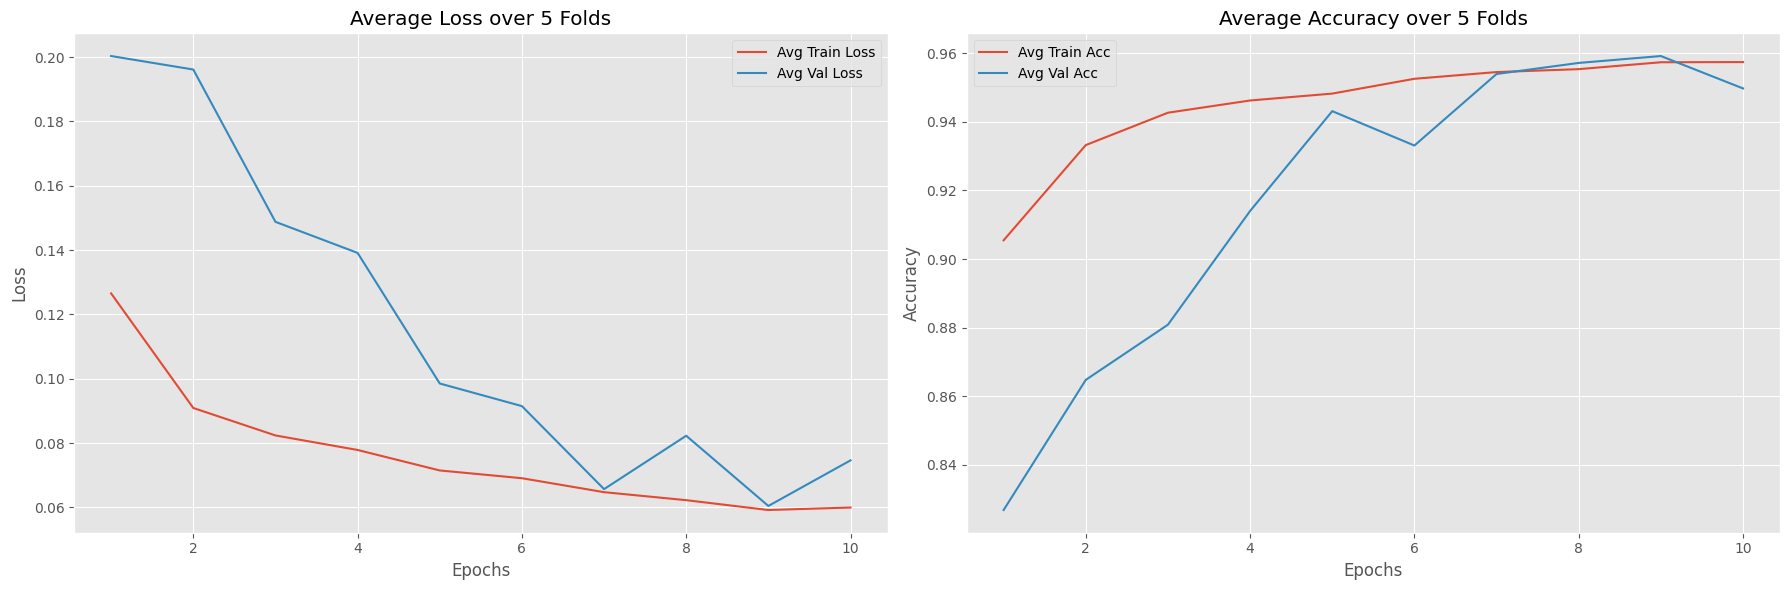

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_history(histories, num_folds):
    plt.style.use("ggplot")
    num_epochs_actual = len(histories[0]["train_loss"])  # Get actual epochs run

    # --- Aggregate histories across folds ---
    avg_train_loss = np.zeros(num_epochs_actual)
    avg_val_loss = np.zeros(num_epochs_actual)
    avg_train_acc = np.zeros(num_epochs_actual)
    avg_val_acc = np.zeros(num_epochs_actual)

    for history in histories:
        epochs_in_hist = len(history["train_loss"])
        avg_train_loss[:epochs_in_hist] += np.array(history["train_loss"])
        avg_val_loss[:epochs_in_hist] += np.array(history["val_loss"])
        avg_train_acc[:epochs_in_hist] += np.array(history["train_acc"])
        avg_val_acc[:epochs_in_hist] += np.array(history["val_acc"])

    avg_train_loss /= len(histories)
    avg_val_loss /= len(histories)
    avg_train_acc /= len(histories)
    avg_val_acc /= len(histories)

    # --- Plotting ---
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))

    # Plot Average Loss
    axs[0].plot(range(1, num_epochs_actual + 1), avg_train_loss, label="Avg Train Loss")
    axs[0].plot(range(1, num_epochs_actual + 1), avg_val_loss, label="Avg Val Loss")
    axs[0].set_title(f"Average Loss over {num_folds} Folds")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid(True)

    # Plot Average Accuracy
    axs[1].plot(range(1, num_epochs_actual + 1), avg_train_acc, label="Avg Train Acc")
    axs[1].plot(range(1, num_epochs_actual + 1), avg_val_acc, label="Avg Val Acc")
    axs[1].set_title(f"Average Accuracy over {num_folds} Folds")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_history(all_fold_histories, 5)

### 🧪 Model Evaluation Function  
Defines a function to evaluate the model on test data and makes predictions for performance analysis.

In [15]:

def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad(): # No need to track gradients during evaluation
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1) # Ensure correct shape and type

            outputs = model(inputs)
            # Apply sigmoid and threshold for predictions
            preds = torch.sigmoid(outputs) > 0.5

            all_preds.extend(preds.cpu().numpy()) # Move predictions to CPU and store
            all_labels.extend(labels.cpu().numpy()) # Move labels to CPU and store

    # Flatten the lists
    all_preds = [p[0] for p in all_preds] # Extract boolean value
    all_labels = [l[0] for l in all_labels] # Extract float value

    # Convert boolean predictions to integers (0 or 1)
    all_preds_int = [int(p) for p in all_preds]
    all_labels_int = [int(l) for l in all_labels]

    return all_labels_int, all_preds_int

# Evaluate if a model was trained and test data exists
if best_model is not None and dataset_sizes["test"] > 0:
    print("\nEvaluating the best model on the test set...")
    test_loader = dataloaders["test"]
    true_labels, predicted_labels = evaluate_model(best_model, test_loader, device)
    print("Evaluation complete.")
else:
    print("\nSkipping test set evaluation as no model was trained or test set is empty.")
    true_labels, predicted_labels = [], [] # Assign empty lists



Evaluating the best model on the test set...
Evaluation complete.


### 📊 Performance Metrics  
Calculates accuracy, F1-score, and generates a detailed classification report for the test set predictions.

In [16]:

if true_labels and predicted_labels:
    print("\nCalculating performance metrics...")
    accuracy = accuracy_score(true_labels, predicted_labels)
    
    # Calculate macro-averaged F1 score (average of F1 scores of both classes)
    f1_macro = f1_score(true_labels, predicted_labels, average='macro')
    
    # Optionally also get per-class F1 scores using `average=None`
    f1_per_class = f1_score(true_labels, predicted_labels, average=None)

    report = classification_report(true_labels, predicted_labels, target_names=class_names)

    print(f"\nTest Accuracy: {accuracy:.4f}")
    print(f"Test Macro-Averaged F1-Score: {f1_macro:.4f}")
    print(f"Per-Class F1-Scores: {f1_per_class}")
    print("\nClassification Report:")
    print(report)
else:
    print("\nSkipping metric calculation as no evaluation was performed.")


Calculating performance metrics...

Test Accuracy: 0.9488
Test Macro-Averaged F1-Score: 0.9369
Per-Class F1-Scores: [0.90945674 0.96431404]

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.87      0.95      0.91       238
   PNEUMONIA       0.98      0.95      0.96       641

    accuracy                           0.95       879
   macro avg       0.93      0.95      0.94       879
weighted avg       0.95      0.95      0.95       879



### 🔍 Confusion Matrix  
Visualizes model performance with a confusion matrix showing true vs. predicted labels.


Generating Confusion Matrix...


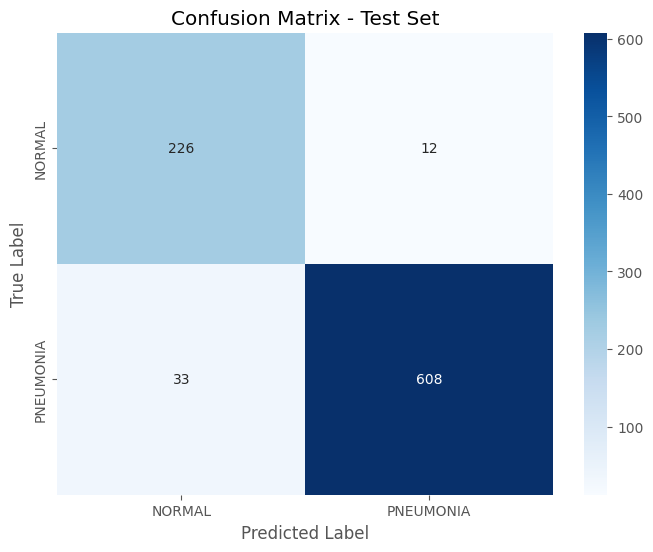


--- Script Execution Finished ---


In [17]:
if true_labels and predicted_labels:
    print("\nGenerating Confusion Matrix...")
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix - Test Set")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
else:
    print("\nSkipping confusion matrix generation.")

print("\n--- Script Execution Finished ---")


Getting predicted probabilities...


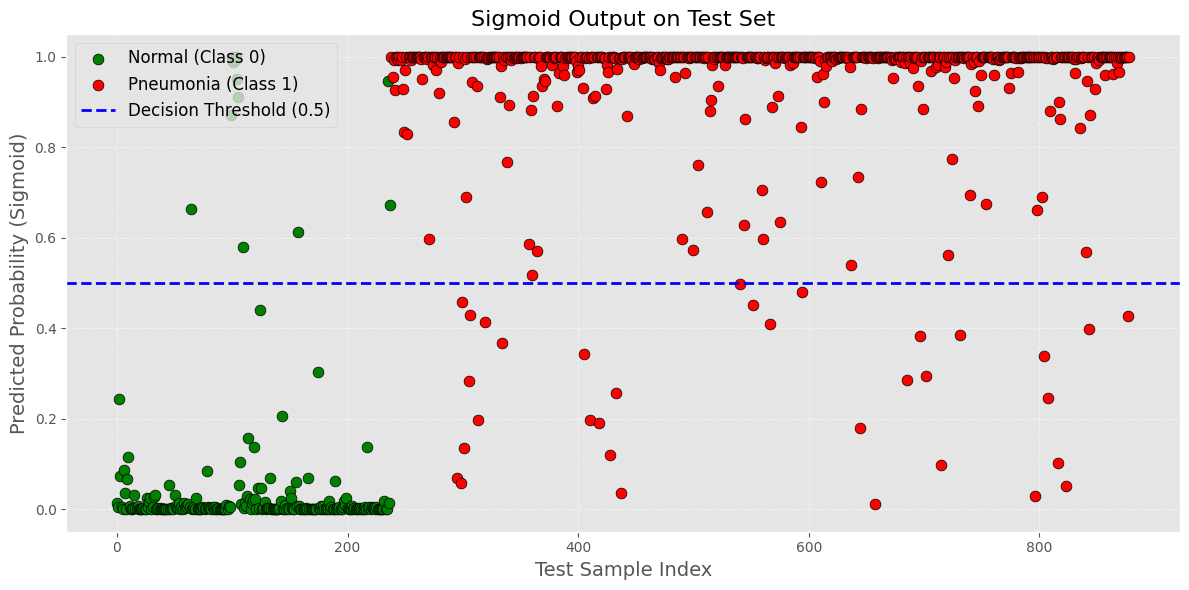

In [18]:

def get_probabilities(model, dataloader, device):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(inputs)
            probs = torch.sigmoid(outputs)  # Get raw probabilities

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return [p[0] for p in all_probs], [int(l[0]) for l in all_labels]

# Get predicted probabilities and true labels
if best_model is not None and dataset_sizes["test"] > 0:
    print("Getting predicted probabilities...")
    test_loader = dataloaders["test"]
    probabilities, true_labels = get_probabilities(best_model, test_loader, device)
else:
    print("Model or test data not available.")
    probabilities, true_labels = [], []

# Plotting the sigmoid prediction graph
if probabilities and true_labels:
    plt.figure(figsize=(12, 6))
    
    # Separate indices by class
    normal_indices = [i for i, label in enumerate(true_labels) if label == 0]
    pneumonia_indices = [i for i, label in enumerate(true_labels) if label == 1]

    # Extract corresponding probabilities
    normal_probs = [probabilities[i] for i in normal_indices]
    pneumonia_probs = [probabilities[i] for i in pneumonia_indices]

    # Plot both classes separately to ensure correct legend entries
    plt.scatter(normal_indices, normal_probs, c='green', label='Normal (Class 0)', edgecolor='k', s=60)
    plt.scatter(pneumonia_indices, pneumonia_probs, c='red', label='Pneumonia (Class 1)', edgecolor='k', s=60)

    # Draw threshold line
    plt.axhline(y=0.5, color='blue', linestyle='--', linewidth=2, label='Decision Threshold (0.5)')

    plt.title("Sigmoid Output on Test Set", fontsize=16)
    plt.xlabel("Test Sample Index", fontsize=14)
    plt.ylabel("Predicted Probability (Sigmoid)", fontsize=14)
    plt.ylim(-0.05, 1.05)
    plt.legend(loc='upper left', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("No probabilities to plot.")

In [19]:
import torch
import torch.nn as nn
from torchvision import models
import matplotlib.pyplot as plt

# Dictionary to store activations
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [20]:
layer_name = "features.denseblock1.denselayer2.conv2"
best_model.eval()
layer = dict([*best_model.named_modules()])[layer_name]
layer.register_forward_hook(get_activation(layer_name))

In [21]:
def get_one_sample_per_class(dataloader, device):
    normal_img, pneumonia_img = None, None
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).long()

            for i in range(inputs.size(0)):
                if labels[i].item() == 0 and normal_img is None:
                    normal_img = inputs[i].unsqueeze(0)
                elif labels[i].item() == 1 and pneumonia_img is None:
                    pneumonia_img = inputs[i].unsqueeze(0)
                if normal_img is not None and pneumonia_img is not None:
                    break
            if normal_img is not None and pneumonia_img is not None:
                break
    return normal_img, pneumonia_img

normal_input, pneumonia_input = get_one_sample_per_class(test_loader, device)

In [22]:
with torch.no_grad():
    best_model(normal_input)
    normal_act = activation[layer_name]

    best_model(pneumonia_input)
    pneumonia_act = activation[layer_name]

In [23]:
def plot_activations(tensor, title="Feature Maps"):
    # tensor shape: [1, C, H, W]
    tensor = tensor.squeeze(0).cpu().numpy()  # Now shape: [C, H, W]

    num_channels = tensor.shape[0]
    rows = 4
    cols = 8
    fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
    fig.suptitle(title, fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < num_channels:
            ax.imshow(tensor[i], cmap='viridis')
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

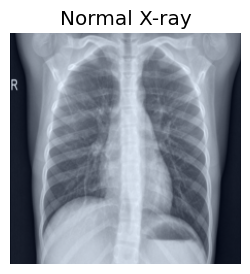

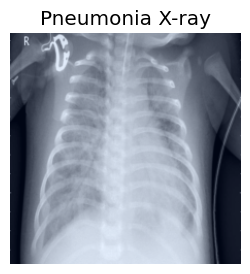

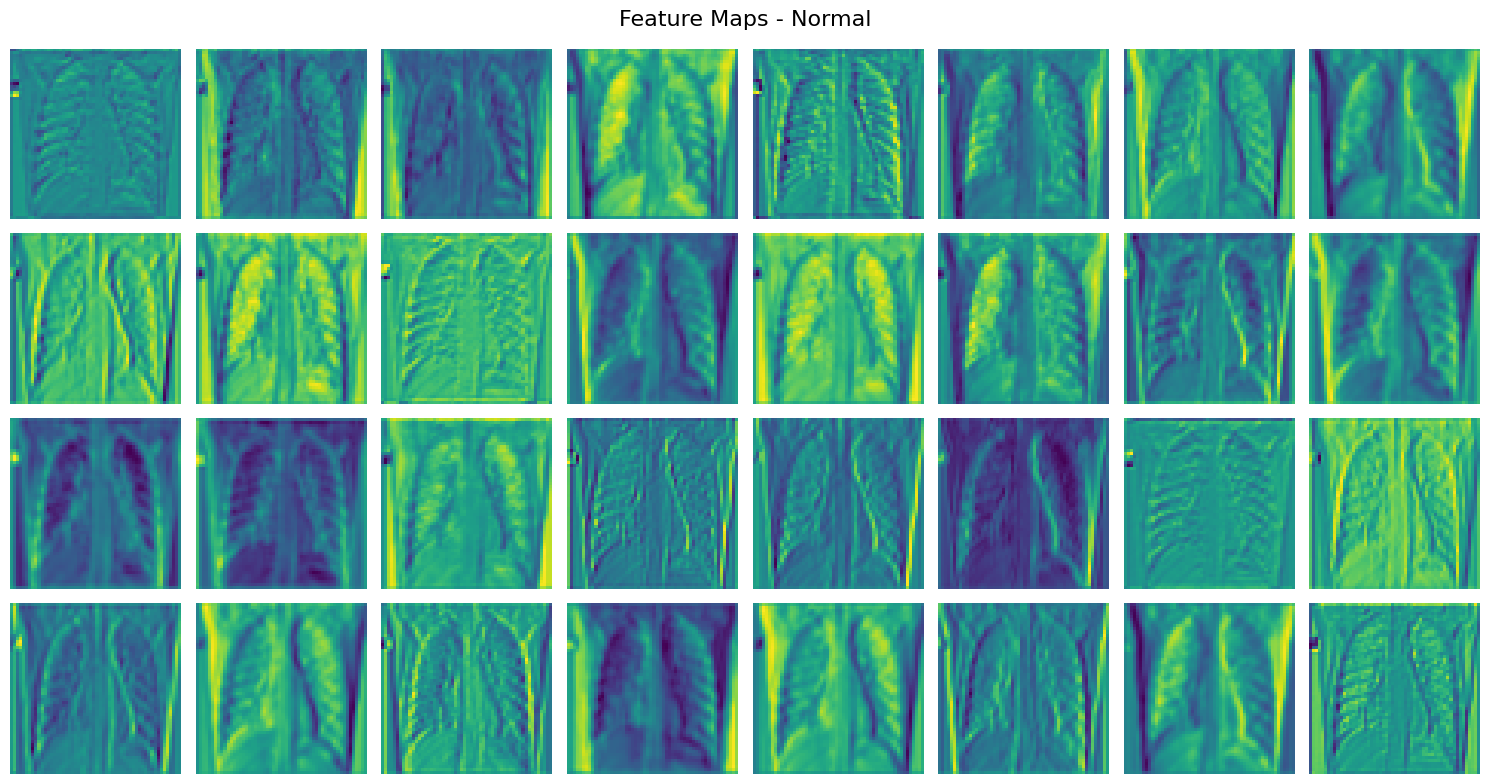

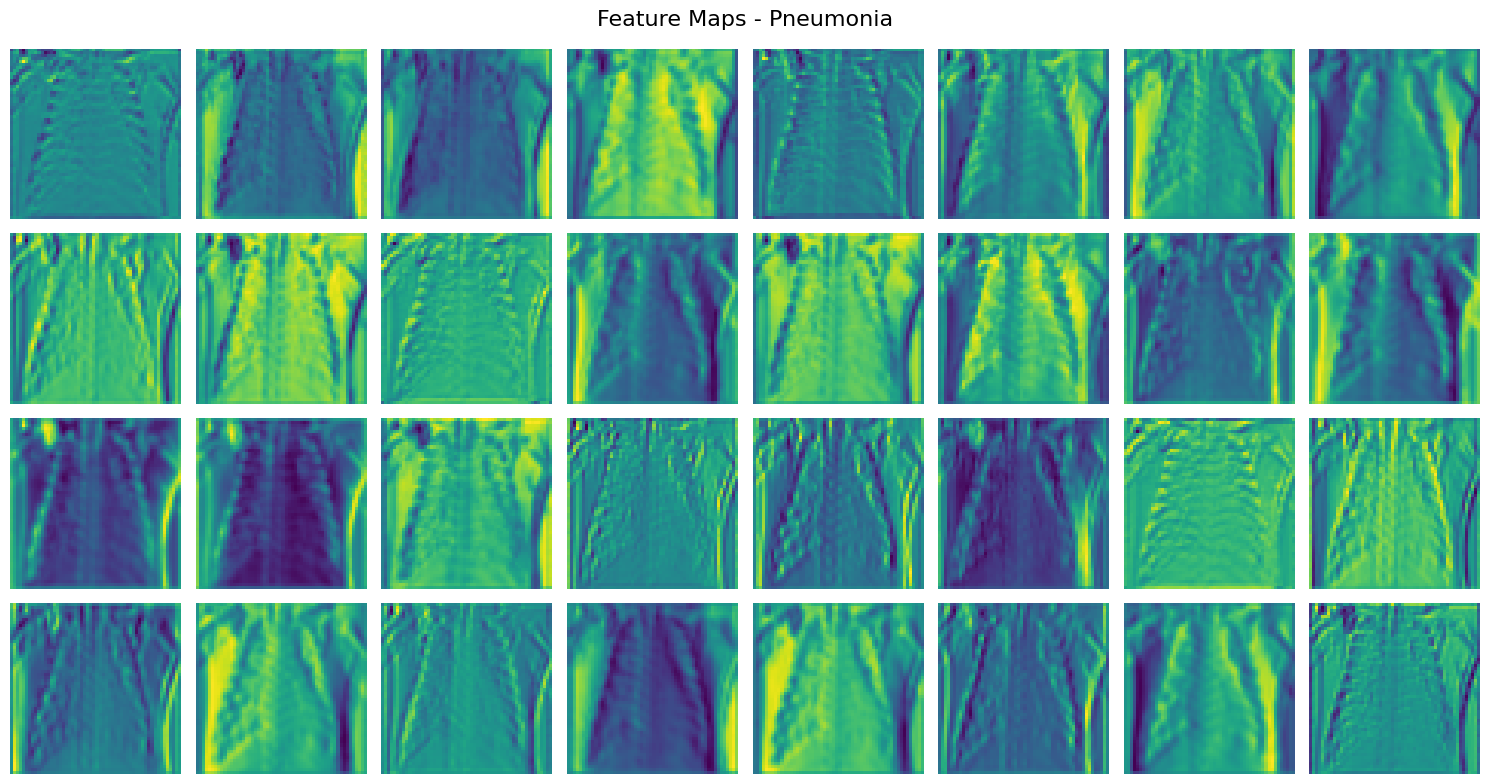

In [24]:
# Show original images
def show_image(img, title):
    img = img.cpu().squeeze().permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())  # Normalize for display
    plt.figure(figsize=(3, 3))
    plt.title(title)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

# Show Normal
show_image(normal_input, "Normal X-ray")

# Show Pneumonia
show_image(pneumonia_input, "Pneumonia X-ray")

# Show feature maps
plot_activations(normal_act, "Feature Maps - Normal")
plot_activations(pneumonia_act, "Feature Maps - Pneumonia")

## 5.💾 Save Trained Model  
Saves the best model weights along with training metadata (like model name, epochs, and learning rate).

### 💿 Save Full Model (Architecture + Weights)

Saves the complete model for later retraining or testing.

In [25]:
# Remove hooks before saving
for module in best_model.modules():
    if hasattr(module, "_forward_hooks"):
        module._forward_hooks.clear()
    if hasattr(module, "_backward_hooks"):
        module._backward_hooks.clear()

# Now save the full model
torch.save(best_model, 'densenet161_full.pth')

In [26]:
FileLink('densenet161_full.pth')

/kaggle/working/densenet161_full.pth

### 🧳 Save Model Weights Only (For Deployment)

Saves only the model weights, which is more efficient for deployment.

In [27]:
# Save state_dict only (better for deployment)
torch.save(best_model.state_dict(), 'densenet161_weights.pth')

In [28]:
FileLink('densenet161_weights.pth')

/kaggle/working/densenet161_weights.pth

### 📦 Archive and Download Dataset Folder

Creates a ZIP archive of the dataset folder and provides a download link.

In [29]:


# Create a zip archive of the folder
shutil.make_archive('chest_xray_stratified', 'zip', '/kaggle/working/chest_xray_stratified')

# Provide a download link
FileLink('chest_xray_stratified.zip')

/kaggle/working/chest_xray_stratified.zip